# Spam Detection 
- [Dataset-link](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

In [1]:
# import libraries
import numpy as np
import pandas as pd

In [2]:
# Read the data
df = pd.read_csv("spam.csv")
# df_= pd.read_csv("mail_data.csv") #they are both same dataset

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## steps

- Data cleaning
- EDA
- Text Preporcessing
- Model Building
- Evaluation
- Inprovement
- Website
- Deploy

In [5]:
df.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace = True)
df.sample(2)

,v1,v2
5149,ham,Pls call me da. What happen.
1783,ham,No dear i do have free messages without any re...


In [6]:
#renaming the columns 
df.rename(columns={'v1':'target','v2':'text'},inplace = True)
df.sample(2)

,target,text
1844,ham,Da is good good player.why he is unsold.
5072,ham,Gud ni8 dear..slp well..take care..swt dreams....


In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [8]:
df["target"] = encoder.fit_transform(df["target"])
df.sample(2)

,target,text
1058,0,Tell me they're female :V how're you throwing ...
4138,0,Ever green quote ever told by Jerry in cartoon...


In [9]:
# checking for missing values

In [10]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
#check for duplicate value

In [12]:
df.duplicated().sum()

403

In [13]:
df = df.drop_duplicates(keep="first")
# df.tail(3)
df.shape

(5169, 2)

# 2.EDA

In [14]:
df["target"].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7fbde3eabe10>,
 [Text(-1.0144997251399075, 0.42519443516002464, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001339, '87.367'),
  Text(0.5533635081542612, -0.23192418555038377, '12.633')])

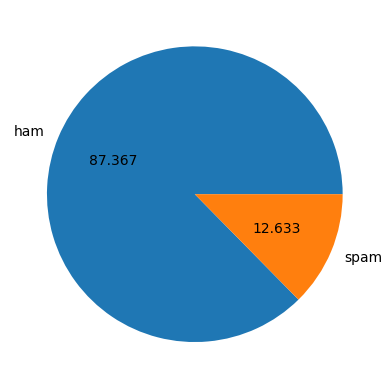

In [15]:
import matplotlib.pyplot as plt
plt.pie(df["target"].value_counts(), labels=["ham","spam"],autopct="%0.3f")

`data is imbalanced`

In [16]:
import nltk
nltk.download("punkt")

[nltk_data] Error loading punkt: <urlopen error [Errno 110] Connection
[nltk_data]     timed out>


False

In [17]:
df["num_characters"] = df["text"].apply(len)
df.sample(3)

,target,text,num_characters
5045,0,Desires- u going to doctor 4 liver. And get a ...,89
251,0,"Wen ur lovable bcums angry wid u, dnt take it ...",179
3001,0,"Excellent, I'll see what riley's plans are",42


In [18]:
#break the sentence into indivisual words
df["num_words"] = df["text"].apply(lambda x:len(nltk.word_tokenize(x)))
df.sample(3)

,target,text,num_characters,num_words
2537,0,That's y we haf to combine n c how lor...,41,12
1345,0,Que pases un buen tiempo or something like that,47,9
3689,0,What happen dear tell me,24,5


In [19]:
df["num_sentences"] = df["text"].apply(lambda x:len(nltk.sent_tokenize(x)))
df.sample(3)

,target,text,num_characters,num_words,num_sentences
5117,0,Aslamalaikkum....insha allah tohar beeen muht ...,88,15,1
4374,1,Ur TONEXS subscription has been renewed and yo...,145,27,3
5480,0,Have you seen who's back at Holby?!,35,10,2


In [20]:
#getting more information about the newly made 3 columns
df[["num_characters","num_words","num_sentences"]].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.924163,18.456761,1.966531
std,58.175349,13.325633,1.449833
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [21]:
# get more info about the ham(not_spam)
df[df["target"] == 0][["num_characters","num_words","num_sentences"]].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.457263,17.123782,1.820195
std,56.357463,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
# get more info about the spam
df[df["target"] == 1][["num_characters","num_words","num_sentences"]].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.978560
std,30.014336,7.011513,1.493185
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


# Data-Viz

In [23]:
#importing modules
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

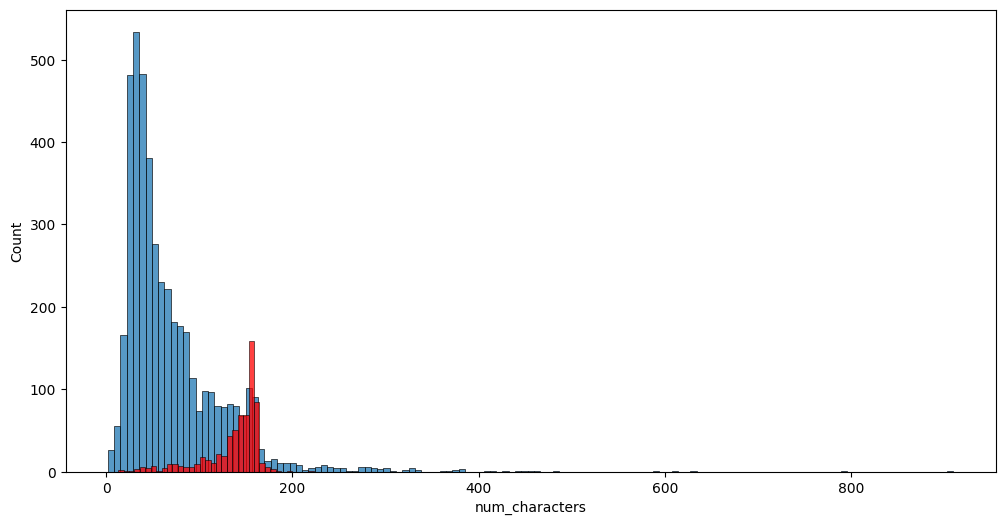

In [24]:
plt.figure(figsize=(12,6))
sns.histplot(df[df["target"] == 0]["num_characters"])
sns.histplot(df[df["target"] == 1]["num_characters"],color="red")

<Axes: xlabel='num_words', ylabel='Count'>

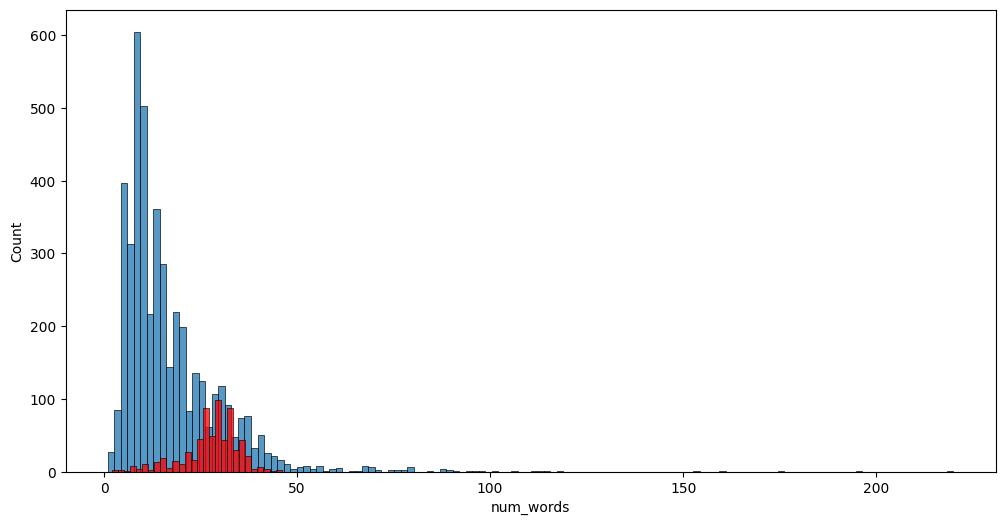

In [25]:
plt.figure(figsize=(12,6))
sns.histplot(df[df["target"] == 0]["num_words"])
sns.histplot(df[df["target"] == 1]["num_words"],color="red")

/home/chaos/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


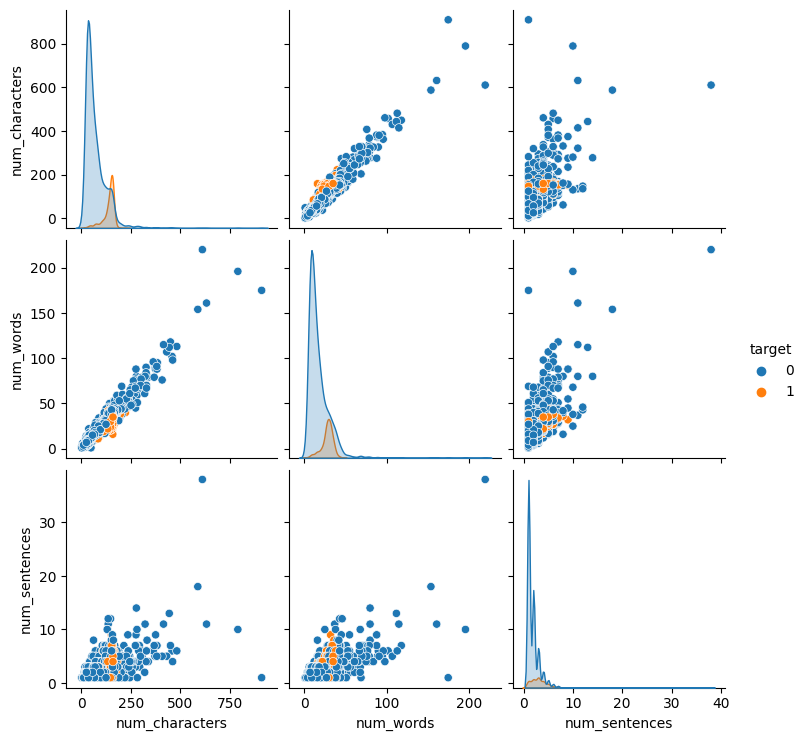

In [26]:
sns.pairplot(df,hue="target")

In [27]:
sns.heatmap(df.corr(),annot=True)

ValueError: could not convert string to float: 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

# Data Preprocessing
- lower case
- tokenization
- removing special char
- removing stop words and punctuation
- stemming

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

def transform_texts(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y.copy()
    y.clear()
    
    ps = PorterStemmer()
    for i in text: 
        if i not in stopwords.words("english") and i not in string.punctuation:
            y.append(ps.stem(i))
            
    text = y.copy()
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)


In [29]:
df["text"][56]

'Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! '

In [30]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem("loving")

'love'

In [31]:
df["transformed_text"] = df["text"].apply(transform_texts)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/chaos/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
